In [2]:
import os

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graspy as gs

import sys
sys.path.append("../../multigraph/")

from experiment import MultiGraphCluster

/home/j1c/graphstats/venv/lib/python3.6/site-packages/graspy/plot/__init__.py:8: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


### Loading and handling the data

In [3]:
def import_edgelist(path, nodetype=int, delimiter=None):
    """
    Function for reading an edgelist and returning a numpy array.
    The order of nodes are sorted by node values.

    Parameters
    ----------
    path : str
    delimiter : str, optional
    
    Returns
    -------
    graph : array-like, shape (n_vertices, n_vertices)
        Adjacency matrix of the graph created from edgelist.
    """
    G = nx.read_weighted_edgelist(path, delimiter=delimiter, nodetype=nodetype)
    graph = nx.to_numpy_array(G, nodelist=sorted(G.nodes), dtype=np.float)

    return gs.utils.import_graph(graph)

In [4]:
df = pd.read_csv('./subject_information.csv')

fmri_path = '../../data/HBN/fmri/desikan/'
fmris = os.listdir(fmri_path)

dmri_path = '../../data/HBN/dwi/desikan/'
dmris = os.listdir(dmri_path)

dmri_graphs = []
fmri_graphs = []

for subject in df['Patient_ID'].values:
    dfile = [i for i in dmris if subject in i][0]
    ffile = [i for i in fmris if subject in i][0]
    dmri_graphs.append(import_edgelist(dmri_path + dfile))
    fmri_graphs.append(import_edgelist(fmri_path + ffile))

In [5]:
print(len(fmri_graphs), len(dmri_graphs))

289 289


### Visualizing age distributions and converting to discrete labels

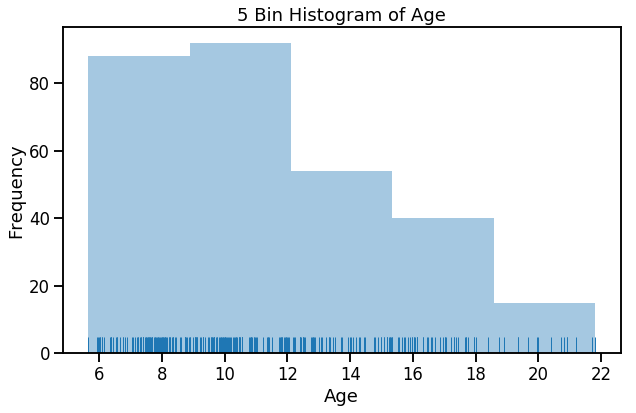

In [6]:
age = df['Age'].values

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.distplot(age, bins=5, kde=False, rug=True)
    plot.set(xlabel='Age', ylabel='Frequency', title='5 Bin Histogram of Age')

In [7]:
age_median = (age < np.median(age)).astype(int)

# Multimodal, multigraph clustering

### HBN Dataset

Data summary
- subjects = 30
- total fmri scans = 289
- total dmri scans = 289
- total scans = 578

Desikan atlas
- num vertices = 70

## Without PTR

Running KMeans on vectorized graphs with 50 clusters.
Running graph embedding
Running cMDS
Running Gaussian Clustering with 50 clusters


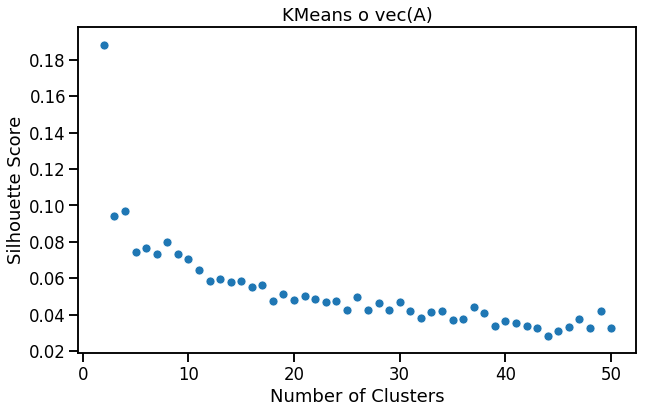

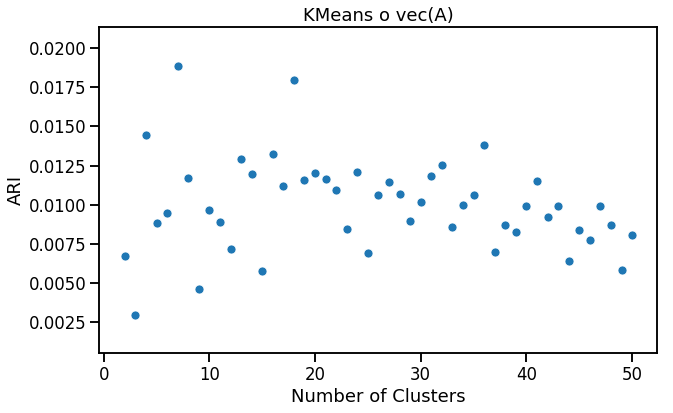

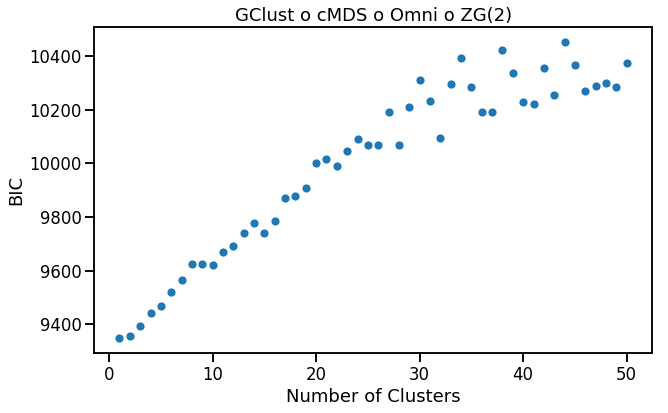

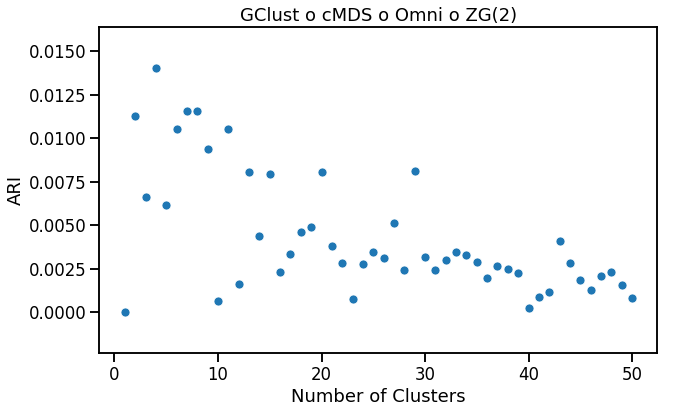

In [9]:
mgc = MultiGraphCluster(transform=None)
mgc.run_experiment(dmri_graphs, fmri_graphs, age_median)

## With PTR

Running KMeans on vectorized graphs with 50 clusters.
Running graph embedding
Running cMDS
Running Gaussian Clustering with 50 clusters


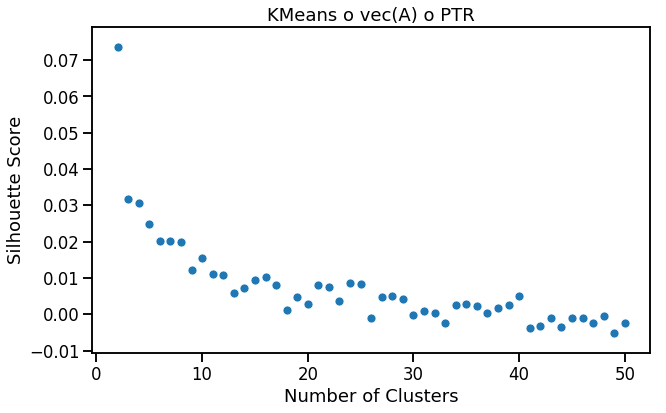

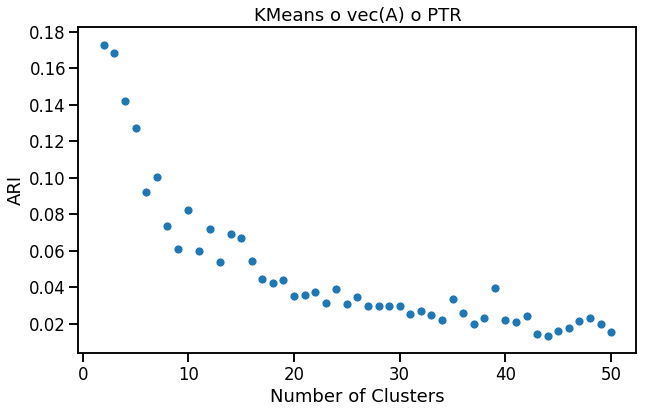

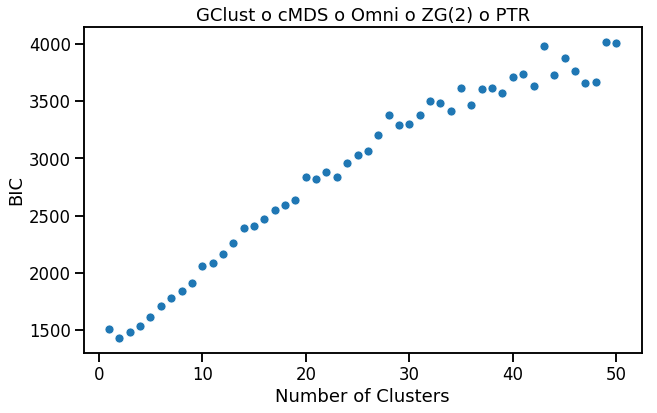

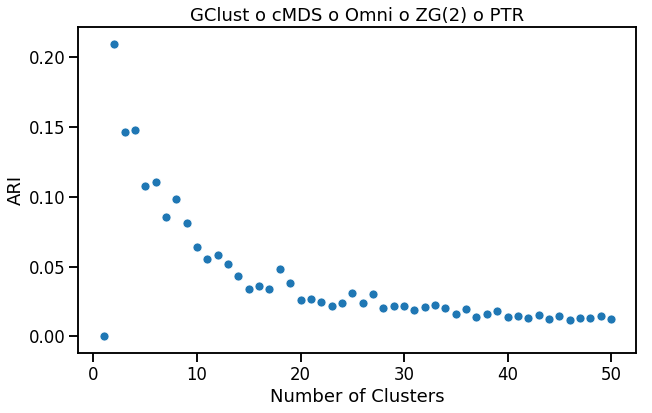

In [8]:
mgc = MultiGraphCluster()
mgc.run_experiment(dmri_graphs, fmri_graphs, age_median)

### Running mgc on results of cMDS and age

In [11]:
from mgcpy.independence_tests.mgc.mgc import MGC

In [15]:
mgc_independence = MGC(mgc.dhat_, age.reshape(-1, 1), None)

pval, data = mgc_independence.p_value()

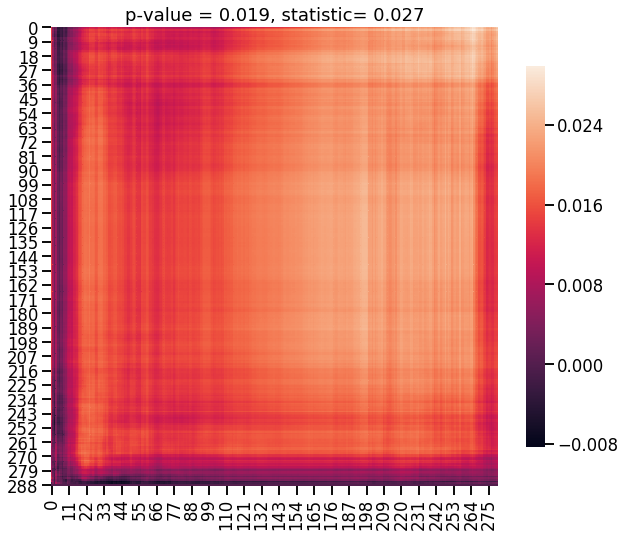

In [37]:
corr_matrix = data['local_correlation_matrix']

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot = sns.heatmap(np.flipud(corr_matrix), ax=ax, square=True, cbar_kws = dict(shrink=0.7))
    plot.set_title('p-value = {:.3f}, statistic= {:.3f}'.format(pval, data['test_statistic']))